<a href="https://colab.research.google.com/github/zhuchangyan/Multimode-fiber-Image-reconstruction/blob/master/DenoisingAutoencoder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denosing Autoencoder
这使用autoencoder写的去噪声代码，测试数据集为Mnist数据集。

9月11日我在与yidong讨论的时候他建议把噪声的格式改一下，因为在真实的Multimode fiber里面不只是对光强的噪声，而是各种模式之间的混合，也就是Mode mixing.


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use `tf.keras.layers.Conv

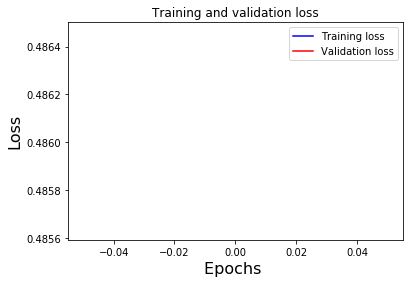

<Figure size 432x288 with 0 Axes>

Epoch: 2/15... Training loss: 0.3831 Validation loss: 0.3816


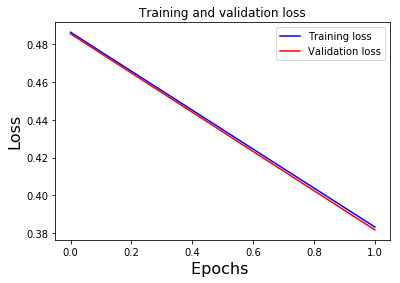

<Figure size 432x288 with 0 Axes>

Epoch: 3/15... Training loss: 0.2131 Validation loss: 0.2134


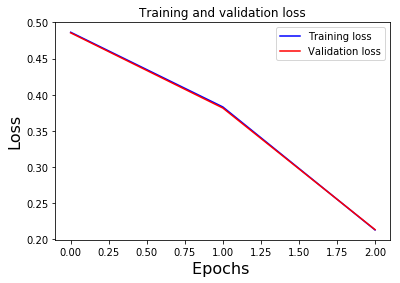

<Figure size 432x288 with 0 Axes>

Epoch: 4/15... Training loss: 0.1824 Validation loss: 0.1827


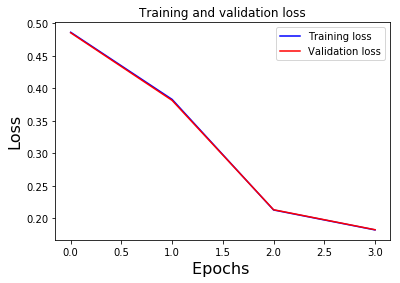

<Figure size 432x288 with 0 Axes>

Epoch: 5/15... Training loss: 0.1621 Validation loss: 0.1646


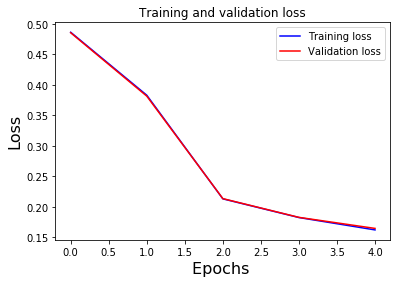

<Figure size 432x288 with 0 Axes>

Epoch: 6/15... Training loss: 0.1565 Validation loss: 0.1591


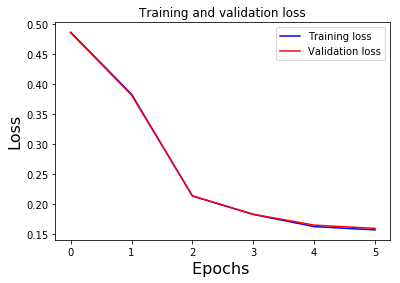

<Figure size 432x288 with 0 Axes>

Epoch: 7/15... Training loss: 0.1439 Validation loss: 0.1434


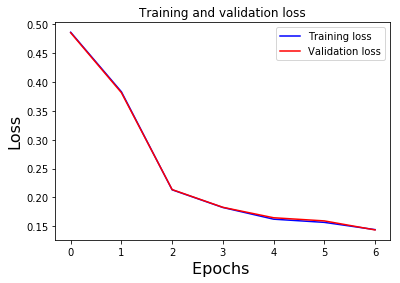

<Figure size 432x288 with 0 Axes>

Epoch: 8/15... Training loss: 0.1394 Validation loss: 0.1390


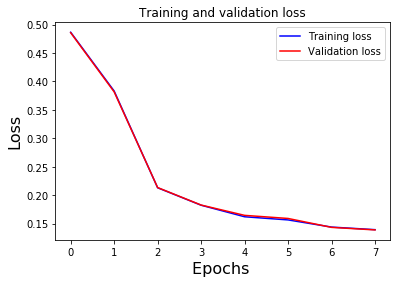

<Figure size 432x288 with 0 Axes>

Epoch: 9/15... Training loss: 0.1312 Validation loss: 0.1311


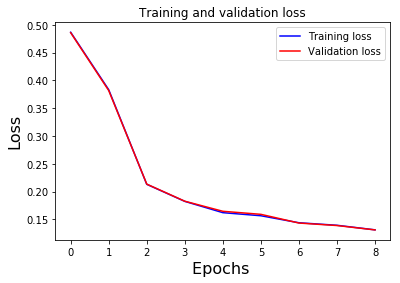

<Figure size 432x288 with 0 Axes>

Epoch: 10/15... Training loss: 0.1279 Validation loss: 0.1256


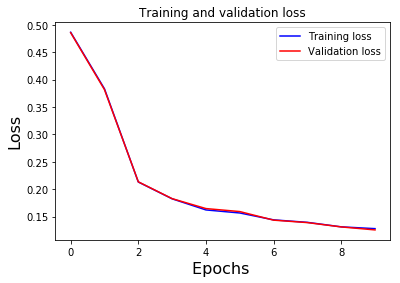

<Figure size 432x288 with 0 Axes>

Epoch: 11/15... Training loss: 0.1281 Validation loss: 0.1311


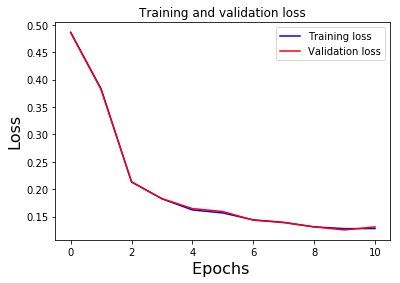

<Figure size 432x288 with 0 Axes>

Epoch: 12/15... Training loss: 0.1316 Validation loss: 0.1336


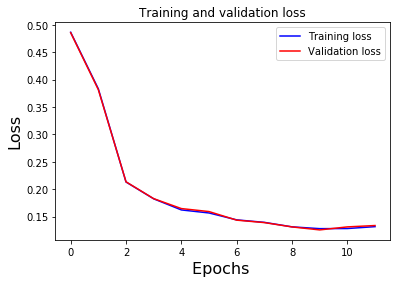

<Figure size 432x288 with 0 Axes>

Epoch: 13/15... Training loss: 0.1273 Validation loss: 0.1264


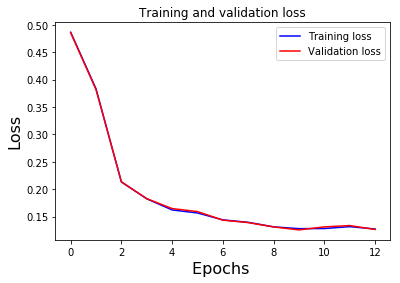

<Figure size 432x288 with 0 Axes>

Epoch: 14/15... Training loss: 0.1199 Validation loss: 0.1205


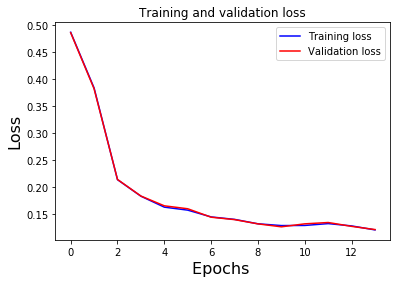

<Figure size 432x288 with 0 Axes>

Epoch: 15/15... Training loss: 0.1262 Validation loss: 0.1265


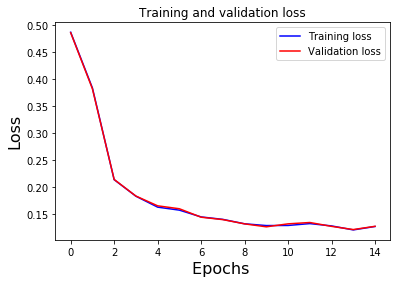

<Figure size 432x288 with 0 Axes>

Original Images


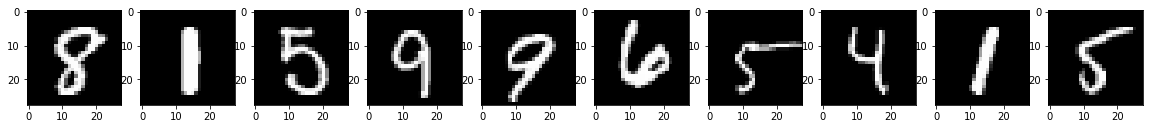

Noisy Images


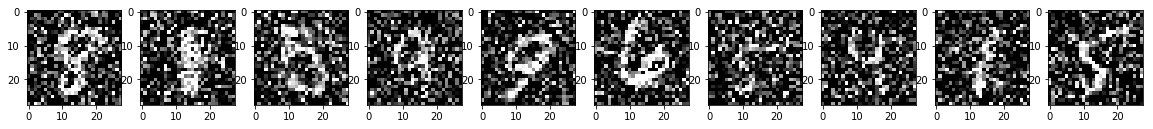

Reconstruction of Noisy Images


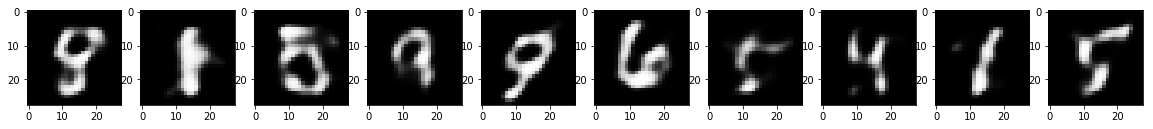

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 导入数据集
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


#lrelu函数
def lrelu(x, alpha=0.1):
    return tf.maximum(alpha * x, x)

#输入到网络的数据
#图片28*28,color_channel是1
inputs_ = tf.placeholder(tf.float32, [None, 28, 28, 1])
#原始数据
targets_ = tf.placeholder(tf.float32, [None, 28, 28, 1])


### Encoder
'''
filters: 32个卷积核
kernel_size: 卷积核大小
strides: 长宽步长都是1
padding: 边缘填充
use_bias: 在卷积中添加偏置
activation: 激活函数
'''
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_, filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )
# 卷积时padding是SAME,所以仍然是28*28
# now 28x28x32
'''
将第一卷积层的结果输入进来
pool_size: 池化窗口
strides: 步长
'''
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,
                                       pool_size=(2, 2),
                                       strides=(2, 2), )

# 池化之后变成了14*14
# now 14x14x32
'''
第二卷积层
参数和第一卷积层相似
'''
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu, )

'''
第二池化层
和上面的池化层参数基本一样
'''
#  now 14x14x32
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,
                                      pool_size=(2, 2),
                                      strides=(2, 2), )
#经过pooling层之后,大小是7x7x32,Encoding完成
# now 7x7x32

#编码之后进行解码
### Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,
                             filters=32,
                             kernel_size=(3, 3),
                             strides=(1, 1),
                             padding='SAME',
                             use_bias=True,
                             activation=lrelu)
    #  现在是7x7x32
    #开始反卷积
    upsamples1 = tf.layers.conv2d_transpose(conv3,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsample1')
    # now 14x14x32
    #反卷积
    upsamples2 = tf.layers.conv2d_transpose(upsamples1,
                                            filters=32,
                                            kernel_size=3,
                                            padding='SAME',
                                            strides=2,
                                            name='upsamples2')
    # now 28x28x32
    #卷积,filter映射成1
    logits = tf.layers.conv2d(upsamples2,
                              filters=1,
                              kernel_size=(3, 3),
                              strides=(1, 1),
                              name='logits',
                              padding='SAME',
                              use_bias=True)
    # 此时的数据是 28x28x1
    # 通过sigmoid传递logits以获得重建图像
    decoded = tf.sigmoid(logits, name='recon')

# 定义损失函数和优化器
loss = tf.nn.sigmoid_cross_entropy_with_logits(
    logits=logits, labels=targets_)

learning_rate = tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# 训练
sess = tf.Session()

saver = tf.train.Saver()
loss = []
valid_loss = []

display_step = 1
epochs = 15
batch_size = 64
lr = 1e-5
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)

for e in range(epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    for ibatch in range(total_batch):
        batch_x = mnist.train.next_batch(batch_size)
        batch_test_x = mnist.test.next_batch(batch_size)
        imgs_test = batch_x[0].reshape((-1, 28, 28, 1))
        noise_factor = 0.5
        x_test_noisy = imgs_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs_test.shape)
        x_test_noisy = np.clip(x_test_noisy, 0., 1.)
        imgs = batch_x[0].reshape((-1, 28, 28, 1))
        x_train_noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: x_train_noisy,
                                                         targets_: imgs, learning_rate: lr})

        batch_cost_test = sess.run(cost, feed_dict={inputs_: x_test_noisy,
                                                    targets_: imgs_test})
    if (e + 1) % display_step == 0:
        print("Epoch: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.4f}".format(batch_cost),
              "Validation loss: {:.4f}".format(batch_cost_test))

    loss.append(batch_cost)
    valid_loss.append(batch_cost_test)
    plt.plot(range(e + 1), loss, 'b', label='Training loss')
    plt.plot(range(e + 1), valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    saver.save(sess, './encode_model/')

batch_x = mnist.test.next_batch(10)
imgs = batch_x[0].reshape((-1, 28, 28, 1))
noise_factor = 0.5
x_test_noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')
print("Original Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(imgs[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(recon_img[i, ..., 0], cmap='gray')
plt.show()
writer.close()
sess.close()


In [0]:
!ls

sample_data


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
open /content/drive/My Drive/Colab Notebooks/Multimode fibers code/CNN_Mnist.ipynb

SyntaxError: ignored

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# List .txt files in the root.
#
# Search query reference:
# https://developers.google.com/drive/v2/web/search-parameters
listed = drive.ListFile({'q': "title contains '.txt' and 'root' in parents"}).GetList()
for file in listed:
  print('title {}, id {}'.format(file['title'], file['id']))

title foo.txt, id 1tnrU6qyrg_1NBjirh3_pfWukfy7IPAZ3


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [0]:
!ls

'My Drive'
